# Cluster, Label, PCA, then visualize
8JAN2020<br>
Richard Kuzma and Iain Cruickshank


### Imports

In [1]:
import pandas as pd, numpy as np, pickle, time, re

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA, KernelPCA

import seaborn as sns
from sklearn.metrics import classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from pprint import pprint

In [2]:
### load df with metadata

load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = '7800_tweets_known_domains_with_metadata.pkl'

with open(load_path + load_name, 'rb') as f:
    metadata_df = pickle.load(f)

    pd.set_option('display.max_columns', None)
metadata_df.head(3)


,created_at,id_str,entities,user,retweet_count,favorite_count,retweeted_status,Hash words,link,urls,first_url,url_total_retweets,url_total_favorites,article_text,article_text_preprocessed,domain,news,science,govt,dubious,not_any,group,month,week_num,no_www,fake_news,conspiracy,lean_left,lean_center,lean_right,lean_not_known,bias
0,2020-02-29 23:17:56+00:00,1.233894e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 1172275165524385798, 'id_str': '1172275...",0.0,0.0,NaN,No hashtags,https://twitter.com/user/status/12338942013953...,[https://nypost.com/2020/02/28/israeli-scienti...,https://nypost.com/2020/02/28/israeli-scientis...,1414.0,111.0,Thanks for contacting us. We've received your...,yaron steinbuch february updated february amid...,nypost.com,0,0,0,1,0,0,2020-02,9,nypost.com,0,0,0,0,1,0,5
1,2020-02-29 23:39:43+00:00,1.233900e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 465592070, 'id_str': '465592070', 'name...",0.0,0.0,NaN,No hashtags,https://twitter.com/user/status/12338996799240...,[https://nypost.com/2020/02/28/israeli-scienti...,https://nypost.com/2020/02/28/israeli-scientis...,310.0,1055.0,"\nNews\n By Yaron Steinbuch \n\tFebruary 28, ...",yaron steinbuch february amid fears looming pa...,nypost.com,0,0,0,1,0,0,2020-02,9,nypost.com,0,0,0,0,1,0,5
2,2020-02-29 23:40:00+00:00,1.233900e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 23081056, 'id_str': '23081056', 'name':...",328.0,0.0,{'created_at': 'Thu Feb 27 23:27:42 +0000 2020...,No hashtags,https://twitter.com/user/status/12338997538151...,[https://time.com/5790545/first-covid-19-vacci...,https://time.com/5790545/first-covid-19-vaccine/,73061.0,2115.0,"Moderna Therapeutics, a biotech company based...",moderna therapeutics biotech company based cam...,time.com,1,0,0,0,0,2,2020-02,9,time.com,0,0,1,0,0,0,3


<br><br><br>
### Make TFIDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=10, max_df=.8)
X = vectorizer.fit_transform(metadata_df.iloc[:, 14])
print('{} articles. Vocabulary: {} words'.format(X.shape[0], X.shape[1]))

### save the vectorizer
src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
tfidf_save_name = 'tfidf_vectorizer_after_fit_transform.pkl'
with open(src_path + tfidf_save_name, 'wb') as f:
    pickle.dump(vectorizer, f)


# keep ID labels with tfidf features
tfidf_feat = pd.DataFrame(data=X.toarray())
id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
id_strings.reset_index(inplace=True, drop=True)
tfidf_with_id_str = pd.concat([id_strings, tfidf_feat], axis=1, ignore_index=True)
tfidf_with_id_str.rename(columns={0: "id_str"}, inplace=True)
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
tfidf_save_name = 'tfidf_7800_articles_df.pkl'

with open(save_path + tfidf_save_name, 'wb') as f:
    pickle.dump(tfidf_with_id_str, f)


7824 articles. Vocabulary: 20266 words


<br><br>
### make PCA

In [4]:
from sklearn.decomposition import PCA
trans = PCA(n_components=2)
pca_feat = trans.fit_transform(tfidf_feat)

# pca_features_df = pd.DataFrame(data = pca_feat, columns = ['principal component 1', 'principal component 2'])

save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
save_name = 'pca_2d_feat_ndarray.pkl'

with open(save_path + save_name, 'wb') as f:
    pickle.dump(pca_feat, f)
    
pca_feat_df = pd.DataFrame(data=pca_feat)
id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
id_strings.reset_index(inplace=True, drop=True)
pca_with_id_str = pd.concat([id_strings, pca_feat_df], axis=1, ignore_index=True)
pca_with_id_str.rename(columns={0: "id_str"}, inplace=True)

save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
save_name = 'pca_2d_7800_articles_df.pkl'

with open(save_path + save_name, 'wb') as f:
    pickle.dump(pca_with_id_str, f)


<br><br><br>
## Load PCA and TFIDF DataFrames

In [5]:
### load tfidf df
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = 'tfidf_7800_articles_df.pkl'

with open(load_path + load_name, 'rb') as f:
    tfidf_df = pickle.load(f)
tfidf_df.head(3)


,id_str,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020

In [6]:
### load pca df
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = 'pca_2d_7800_articles_df.pkl'

with open(load_path + load_name, 'rb') as f:
    pca_df = pickle.load(f)


pca_feat = pca_df.iloc[:, 1:]
pca_df.head()

,id_str,1,2
0,1.233894e+18,-0.043065,0.001511
1,1.233900e+18,-0.044881,0.006028
2,1.233900e+18,-0.065536,-0.018409
3,1.233900e+18,0.078659,0.001760
4,1.233904e+18,-0.023536,-0.024679


In [7]:
### same number of articles for each
assert(pca_df.shape[0] == tfidf_df.shape[0] == metadata_df.shape[0])

<br><br><br>
## KMeans Clustering, apply labels

In [8]:
tfidf_feat = tfidf_df.iloc[:, 1:]

print('KMeans of TFIDF Features')
print('7800 articles, all domains, 20k vocab...\n')

preds_dict = {}
silhouettes_dict = {}

n_clusters = range(2,21)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(tfidf_feat)
    preds = kmeans.predict(tfidf_feat)
    silhouette = silhouette_score(tfidf_feat, preds)
    
    preds_dict['k_means_' + str(n_cluster)] = preds
    silhouettes_dict['k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))



KMeans of TFIDF Features
7800 articles, all domains, 20k vocab...

Silhouette score for 2 clusters: 0.0029818176502873577
Silhouette score for 3 clusters: 0.009956029876806034
Silhouette score for 4 clusters: 0.014578052263252579
Silhouette score for 5 clusters: 0.02154415278905567
Silhouette score for 6 clusters: 0.024637419641680362
Silhouette score for 7 clusters: 0.027683243858940155
Silhouette score for 8 clusters: 0.03125097222831834
Silhouette score for 9 clusters: 0.03255170739012799
Silhouette score for 10 clusters: 0.03531808625549492
Silhouette score for 11 clusters: 0.0365616563280217
Silhouette score for 12 clusters: 0.042817056166725875
Silhouette score for 13 clusters: 0.045407876029621895
Silhouette score for 14 clusters: 0.042615687076869656
Silhouette score for 15 clusters: 0.04788351266293967
Silhouette score for 16 clusters: 0.04996286207331911
Silhouette score for 17 clusters: 0.048557052745458365
Silhouette score for 18 clusters: 0.05286280592559002
Silhouette sco

<br><br><br>
## KMedoids

In [9]:
! pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

You should consider upgrading via the '/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/bin/python3.7 -m pip install --upgrade pip' command.


In [10]:
print('KMedoids of TFIDF Features with Cosine Distance')
print('7800 articles, all domains, 20k vocab\n')

medoids_preds_dict = {}
medoids_silhouettes_dict = {}

n_clusters = range(2,21)
for n_cluster in n_clusters:
    kmedoids = KMedoids(n_clusters=n_cluster, metric='cosine', 
                    init='heuristic', max_iter=300, random_state=42).fit(tfidf_feat)
    preds = kmedoids.labels_
    silhouette = silhouette_score(tfidf_feat, preds)
    
    medoids_preds_dict['k_medoids_' + str(n_cluster)] = preds
    medoids_silhouettes_dict['k_medoids_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster, silhouette))



KMedoids of TFIDF Features with Cosine Distance
7800 articles, all domains, 20k vocab

Silhouette score for 2 clusters: 0.006113797478326438
Silhouette score for 3 clusters: 0.005241909561045159
Silhouette score for 4 clusters: 0.007426777884571583
Silhouette score for 5 clusters: 0.00784238923478003
Silhouette score for 6 clusters: 0.007787222860031944
Silhouette score for 7 clusters: 0.010994649424737797
Silhouette score for 8 clusters: 0.011318935036167295
Silhouette score for 9 clusters: 0.005434884427135362
Silhouette score for 10 clusters: 0.00868948733104766
Silhouette score for 11 clusters: 0.009078806836350404
Silhouette score for 12 clusters: 0.0095100379671199


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 12 is empty! self.labels_[self.medoid_indices_[12]] may not be labeled with its corresponding cluster (12).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 13 clusters: 0.00958378619908967


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 14 clusters: 0.009945699915894776


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 15 clusters: 0.011628710156383485


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 16 clusters: 0.013110355829051032


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 17 clusters: 0.014255962075605646


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 18 clusters: 0.0159959474598777


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 19 clusters: 0.015488172175475193


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  "its corresponding cluster ({k}).".format(k=k)


Silhouette score for 20 clusters: 0.02465165886683084


In [36]:
### PCA features
print('KMeans of PCA Features')
print('7800 articles, all domains, 20k vocab...\n')

pca_kmeans_preds_dict = {}
pca_kmeans_silhouettes_dict = {}

n_clusters = range(2,21)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(pca_feat)
    preds = kmeans.predict(pca_feat)
    silhouette = silhouette_score(pca_feat, preds)
    
    pca_kmeans_preds_dict['pca_k_means_' + str(n_cluster)] = preds
    pca_kmeans_silhouettes_dict['pca_k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))


KMeans of PCA Features
7800 articles, all domains, 20k vocab...

Silhouette score for 2 clusters: 0.8535027510715453
Silhouette score for 3 clusters: 0.8422807719886332
Silhouette score for 4 clusters: 0.45673128553273357
Silhouette score for 5 clusters: 0.3871445477833784
Silhouette score for 6 clusters: 0.42278308138664017
Silhouette score for 7 clusters: 0.3994834462437312
Silhouette score for 8 clusters: 0.39041529391725244
Silhouette score for 9 clusters: 0.3775302563249958
Silhouette score for 10 clusters: 0.3899495885916279
Silhouette score for 11 clusters: 0.3776823336988977
Silhouette score for 12 clusters: 0.38996294202966647
Silhouette score for 13 clusters: 0.3795789711997774
Silhouette score for 14 clusters: 0.3797405868623782
Silhouette score for 15 clusters: 0.3826689084975312
Silhouette score for 16 clusters: 0.38594116986392796
Silhouette score for 17 clusters: 0.3737507342530627
Silhouette score for 18 clusters: 0.36644736453708404
Silhouette score for 19 clusters: 0.

In [37]:
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
preds_dict_save_name = 'kmeans_preds_dict.pkl'
silhouettes_dict_save_name = 'kmeans_silhouettes_dict.pkl'
medoids_preds_dict_save_name = 'kmedoids_preds_dict.pkl'
medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict.pkl'
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict.pkl'
pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict.pkl'

# KMeans
with open(save_path + preds_dict_save_name, 'wb') as f:
    pickle.dump(preds_dict, f)
    
with open(save_path + silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(silhouettes_dict, f)
    
# KMedoids
with open(save_path + medoids_preds_dict_save_name, 'wb') as f:
    pickle.dump(medoids_preds_dict, f)
    
with open(save_path + medoids_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(medoids_silhouettes_dict, f)
    

# PCA KMeans
with open(save_path + pca_kmeans_preds_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_preds_dict, f)
    
with open(save_path + pca_kmeans_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_silhouettes_dict, f)


<br><br><br>
# Open preds and silhouettes dictionaries
<br><br><br>


In [38]:
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
preds_dict_save_name = 'kmeans_preds_dict.pkl'
silhouettes_dict_save_name = 'kmeans_silhouettes_dict.pkl'
medoids_preds_dict_save_name = 'kmedoids_preds_dict.pkl'
medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict.pkl'
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict.pkl'
pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict.pkl'

# KMeans
with open(save_path + preds_dict_save_name, 'rb') as f:
    preds_dict = pickle.load(f)
    
with open(save_path + silhouettes_dict_save_name, 'rb') as f:
    silhouettes_dict = pickle.load(f)
    
# KMedoids
with open(save_path + medoids_preds_dict_save_name, 'rb') as f:
    medoids_preds_dict = pickle.load(f)
    
with open(save_path + medoids_silhouettes_dict_save_name, 'rb') as f:
    medoids_silhouettes_dict = pickle.load(f)
    
# PCA KMeans
with open(save_path + pca_kmeans_preds_dict_save_name, 'rb') as f:
    pca_kmeans_preds_dict = pickle.load(f)
    
with open(save_path + pca_kmeans_silhouettes_dict_save_name, 'rb') as f:
    pca_kmeans_silhouettes_dict = pickle.load(f)

<br><br><br>
### Plot Silhouette Scores

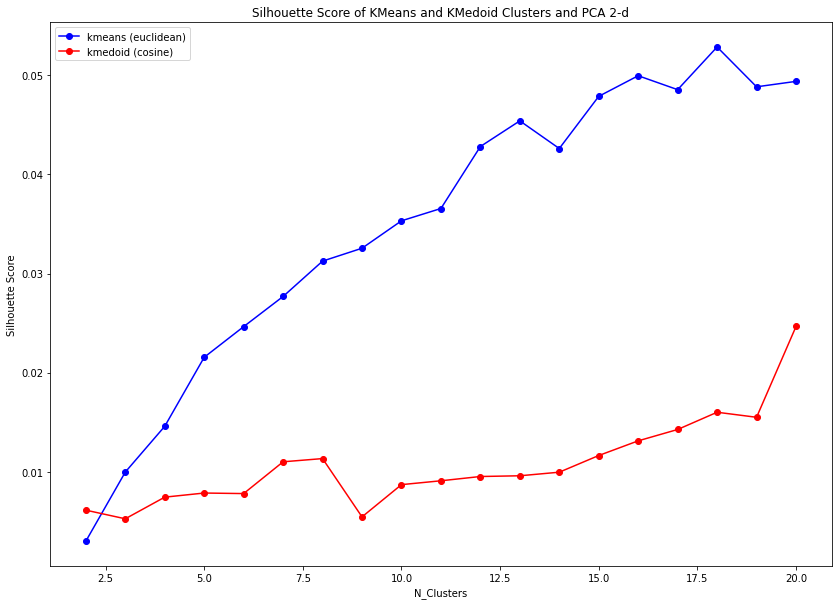

In [39]:
plt.figure(figsize=(14,10))
plt.plot(n_clusters, silhouettes_dict.values(), 'bo-', label='kmeans (euclidean)')
plt.plot(n_clusters, medoids_silhouettes_dict.values(), 'ro-', label='kmedoid (cosine)')

plt.title('Silhouette Score of KMeans and KMedoid Clusters and PCA 2-d')
plt.ylabel('Silhouette Score')
plt.xlabel('N_Clusters')
plt.legend()
plt.show()

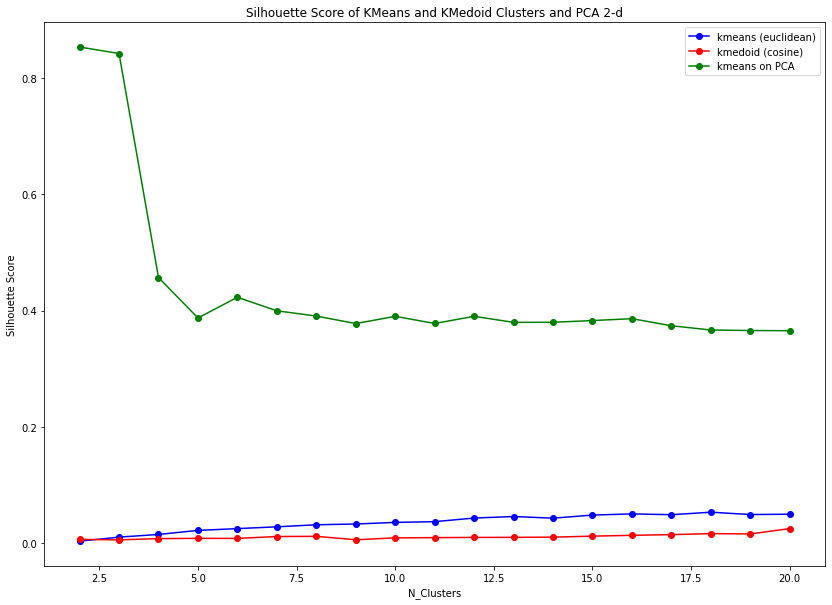

In [40]:
plt.figure(figsize=(14,10))
plt.plot(n_clusters, silhouettes_dict.values(), 'bo-', label='kmeans (euclidean)')
plt.plot(n_clusters, medoids_silhouettes_dict.values(), 'ro-', label='kmedoid (cosine)')
plt.plot(n_clusters, pca_kmeans_silhouettes_dict.values(), 'go-', label='kmeans on PCA')

plt.title('Silhouette Score of KMeans and KMedoid Clusters and PCA 2-d')
plt.ylabel('Silhouette Score')
plt.xlabel('N_Clusters')
plt.legend()
plt.show()

<br><br><br>
## Adjusted Rand Index / Adjusted Mutual Information Score

In [14]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

In [15]:
print('Domain Group vs Bias')
print('ARI: {}'.format(adjusted_rand_score(metadata_df['group'].tolist(), metadata_df['bias'].tolist())))
print('AMI: {}'.format(adjusted_mutual_info_score(metadata_df['group'].tolist(), metadata_df['bias'].tolist())))


Domain Group vs Bias
ARI: 0.17312316101024725
AMI: 0.4030388248520749


In [16]:
domains_vs_kmeans_dict = {}
for i in n_clusters:
    key = 'k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['group'].tolist(), preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['group'].tolist(), preds_dict[key])
    domains_vs_kmeans_dict[key] = (ARI, AMI)

print('Domain Groups vs KMeans Clusters, sorted by ARI')
pprint(sorted(domains_vs_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nDomain Groups vs KMeans Clusters, sorted by AMI')
pprint(sorted(domains_vs_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

Domain Groups vs KMeans Clusters, sorted by ARI
[('k_means_14', (0.03436666917046164, 0.17251929878648165)),
 ('k_means_13', (0.034332195997200526, 0.17232900998952433)),
 ('k_means_18', (0.024993867956754123, 0.17250129738666642)),
 ('k_means_10', (0.022436076103861474, 0.16498270272361257)),
 ('k_means_16', (0.021698549249790762, 0.18171851411537)),
 ('k_means_11', (0.02088489956102763, 0.16471400338716335)),
 ('k_means_15', (0.02054336226930716, 0.16455358226498978)),
 ('k_means_17', (0.008881343125030488, 0.1547541838871843)),
 ('k_means_12', (0.0072706523261892066, 0.1501326984899173)),
 ('k_means_8', (0.006865375456782739, 0.15753038880833117)),
 ('k_means_20', (0.005771373857126982, 0.1644010883409406)),
 ('k_means_7', (0.003975747290005749, 0.14742710030500586)),
 ('k_means_19', (0.0024321419586982636, 0.16639761907235545)),
 ('k_means_9', (-0.008268424021478543, 0.1390304313043303)),
 ('k_means_6', (-0.05010543187681462, 0.10845080427702315)),
 ('k_means_2', (-0.05075958990444

In [17]:
bias_vs_kmeans_dict = {}
for i in n_clusters:
    key = 'k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['bias'].tolist(), preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['bias'].tolist(), preds_dict[key])
    bias_vs_kmeans_dict[key] = (ARI, AMI)

print('Political Bias vs KMeans Clusters, sorted by ARI')
pprint(sorted(bias_vs_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nPolitical Bias vs KMeans Clusters, sorted by AMI')
pprint(sorted(bias_vs_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

Political Bias vs KMeans Clusters, sorted by ARI
[('k_means_9', (0.03242819338563017, 0.14467422334978775)),
 ('k_means_20', (0.03157412068670636, 0.1671821741078593)),
 ('k_means_12', (0.027392819401630325, 0.15073207528718266)),
 ('k_means_19', (0.026039062516801166, 0.16875803483322882)),
 ('k_means_7', (0.02158173589842718, 0.14201694111268648)),
 ('k_means_8', (0.017629754920982458, 0.1462027955685792)),
 ('k_means_10', (0.01172039421250968, 0.157919438757301)),
 ('k_means_16', (0.010890011769889765, 0.18446406103057045)),
 ('k_means_17', (0.01064106611326194, 0.14129244065004537)),
 ('k_means_11', (0.007352045109792137, 0.15431599811958085)),
 ('k_means_15', (0.0052272086656449095, 0.15153363806359027)),
 ('k_means_18', (0.0005069164275069972, 0.1533722709144488)),
 ('k_means_13', (-0.002173107836355758, 0.14443286693303092)),
 ('k_means_14', (-0.0034618291474245496, 0.14446055021735735)),
 ('k_means_6', (-0.013813412874800939, 0.1433801968779474)),
 ('k_means_4', (-0.01574947613

In [18]:
domains_vs_kmedoids_dict = {}
for i in n_clusters:
    key = 'k_medoids_' + str(i)
    ARI = adjusted_rand_score(metadata_df['group'].tolist(), medoids_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['group'].tolist(), medoids_preds_dict[key])
    domains_vs_kmedoids_dict[key] = (ARI, AMI)

print('Domain Groups vs KMedoids Clusters, sorted by ARI')
pprint(sorted(domains_vs_kmedoids_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nDomain Groups vs KMedoids Clusters, sorted by AMI')
pprint(sorted(domains_vs_kmedoids_dict.items(), key=lambda item: item[1][1], reverse=True))

    

Domain Groups vs KMedoids Clusters, sorted by ARI
[('k_medoids_2', (0.067931903103523, 0.04868293466415778)),
 ('k_medoids_3', (0.04211077848071256, 0.05721918014590991)),
 ('k_medoids_4', (0.016490980882240082, 0.05594574001652378)),
 ('k_medoids_5', (0.012957204143860535, 0.05943237494876175)),
 ('k_medoids_20', (0.010647413242818222, 0.08486159803740581)),
 ('k_medoids_6', (0.008329290951732012, 0.058252167877346286)),
 ('k_medoids_19', (0.007320022125965729, 0.07518663893336298)),
 ('k_medoids_18', (0.0070988110780173, 0.07666769166025732)),
 ('k_medoids_17', (0.0038796943698665405, 0.07442652133789764)),
 ('k_medoids_16', (-0.015337189965617462, 0.05083613795943056)),
 ('k_medoids_15', (-0.01792422626772313, 0.05005119380281646)),
 ('k_medoids_12', (-0.018439780768277077, 0.05194251191171509)),
 ('k_medoids_13', (-0.018686278659793287, 0.05078110410213788)),
 ('k_medoids_14', (-0.01968633595746121, 0.05019827916345148)),
 ('k_medoids_10', (-0.019810413616823692, 0.0544239523718812

In [19]:
bias_vs_kmedoids_dict = {}
for i in n_clusters:
    key = 'k_medoids_' + str(i)
    ARI = adjusted_rand_score(metadata_df['bias'].tolist(), medoids_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['bias'].tolist(), medoids_preds_dict[key])
    bias_vs_kmedoids_dict[key] = (ARI, AMI)

print('Political Bias vs KMedoids Clusters, sorted by ARI')
pprint(sorted(bias_vs_kmedoids_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nPolitical Bias vs KMedoids Clusters, sorted by AMI')
pprint(sorted(bias_vs_kmedoids_dict.items(), key=lambda item: item[1][1], reverse=True))


Political Bias vs KMedoids Clusters, sorted by ARI
[('k_medoids_16', (0.02891129356283669, 0.04057984552090455)),
 ('k_medoids_14', (0.028828409629981528, 0.03568039672771174)),
 ('k_medoids_15', (0.02866471636516213, 0.040377360902587964)),
 ('k_medoids_13', (0.028345166380311915, 0.03589130517100983)),
 ('k_medoids_12', (0.027822620750663205, 0.03538902605760392)),
 ('k_medoids_17', (0.025792669091889278, 0.061801572671453746)),
 ('k_medoids_10', (0.025185117860330567, 0.031118874280625413)),
 ('k_medoids_11', (0.024958562188427492, 0.030021862238745423)),
 ('k_medoids_20', (0.02167820976194099, 0.060738343802628054)),
 ('k_medoids_8', (0.020597500296900922, 0.029278455335492636)),
 ('k_medoids_19', (0.01982860323595866, 0.055508598476957396)),
 ('k_medoids_9', (0.019660494881774144, 0.022000666303435546)),
 ('k_medoids_18', (0.01947542601342209, 0.06232582289985227)),
 ('k_medoids_6', (0.01476861006994317, 0.02255379873861266)),
 ('k_medoids_7', (0.013564459768933827, 0.025520164080

In [41]:
domains_vs_pca_kmeans_dict = {}
for i in n_clusters:
    key = 'pca_k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['group'].tolist(), pca_kmeans_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['group'].tolist(), pca_kmeans_preds_dict[key])
    domains_vs_pca_kmeans_dict[key] = (ARI, AMI)

print('Domain Groups vs PCA KMeans Clusters, sorted by ARI')
pprint(sorted(domains_vs_pca_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nDomain Groups vs PCA KMeans Clusters, sorted by AMI')
pprint(sorted(domains_vs_pca_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

Domain Groups vs PCA KMeans Clusters, sorted by ARI
[('pca_k_means_5', (0.05079031456306613, 0.13003189198173964)),
 ('pca_k_means_6', (0.02689189415147311, 0.12110586337310449)),
 ('pca_k_means_7', (0.026632190410332164, 0.12424758647127139)),
 ('pca_k_means_14', (0.025202601498818363, 0.12891012979740343)),
 ('pca_k_means_13', (0.02518999290983394, 0.1292305817279421)),
 ('pca_k_means_15', (0.023779907026766585, 0.12641346002876347)),
 ('pca_k_means_16', (0.023270754293200874, 0.12582758818479323)),
 ('pca_k_means_11', (0.023131498183348864, 0.12075532650754665)),
 ('pca_k_means_8', (0.023027559040626273, 0.1233257129612258)),
 ('pca_k_means_10', (0.022293074712858678, 0.12113921978874868)),
 ('pca_k_means_17', (0.021021694542661618, 0.12307891088079073)),
 ('pca_k_means_18', (0.019921440459463157, 0.12304746994166489)),
 ('pca_k_means_20', (0.019666943189123903, 0.12161764070992027)),
 ('pca_k_means_19', (0.0188259322271829, 0.1215612229831166)),
 ('pca_k_means_12', (0.0177297513220

In [42]:
bias_vs_pca_kmeans_dict = {}
for i in n_clusters:
    key = 'pca_k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['bias'].tolist(), pca_kmeans_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['bias'].tolist(), pca_kmeans_preds_dict[key])
    bias_vs_pca_kmeans_dict[key] = (ARI, AMI)

print('Political Bias vs PCA KMeans Clusters, sorted by ARI')
pprint(sorted(bias_vs_pca_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nPolitical Bias vs PCA KMeans Clusters, sorted by AMI')
pprint(sorted(bias_vs_pca_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

Political Bias vs PCA KMeans Clusters, sorted by ARI
[('pca_k_means_6', (0.04910479185636993, 0.08394558382886558)),
 ('pca_k_means_12', (0.02511941428403775, 0.08896954686940503)),
 ('pca_k_means_17', (0.024034979698202757, 0.08661842500721682)),
 ('pca_k_means_13', (0.023552117216993015, 0.08726048116672282)),
 ('pca_k_means_16', (0.023539960905719973, 0.0874732535090613)),
 ('pca_k_means_14', (0.021549173068143065, 0.08691106565792688)),
 ('pca_k_means_10', (0.020560715001320777, 0.08837359973900345)),
 ('pca_k_means_15', (0.020539047651207797, 0.08662613516449871)),
 ('pca_k_means_11', (0.02046860801620295, 0.08700628365302782)),
 ('pca_k_means_18', (0.020465590366468178, 0.08507632121298264)),
 ('pca_k_means_19', (0.019102244293144194, 0.08354465717732745)),
 ('pca_k_means_20', (0.018604134227144895, 0.0850703753010833)),
 ('pca_k_means_4', (0.01743592152534706, 0.06139199974401392)),
 ('pca_k_means_5', (0.014982376115110078, 0.0763540704140018)),
 ('pca_k_means_9', (0.01355307512

<br><br><br><br><br>
# ===========================================
# ===========================================
<br><br><br><br><br>
# Plotting

### Plot PCA scatter plot with clustering labels for colors

In [20]:
color_dict_labels = {'0': 'xkcd:cyan', '1': 'xkcd:light green', '2': 'xkcd:orange',
                     '3': 'xkcd:dark green', '4': 'xkcd:pink', '5': 'xkcd:plum',
                     '6': 'xkcd:olive', '7': 'xkcd:blue', '8': 'xkcd:salmon',
                     '9': 'xkcd:maroon', '10': 'xkcd:magenta', '11': 'xkcd:violet',
                     '12': 'xkcd:green', '13': 'xkcd:navy blue', '14': 'xkcd:yellow'
                    }

def plot_pca_clustering(num_clusters=4, cluster_type='kmeans'):
    
    print('Num clusters: {}'.format(num_clusters))
    print('cluster type: ' + cluster_type)
    
    
    plt.figure(figsize=(14,10))
    if cluster_type == 'kmeans':
        key = 'k_means_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    elif cluster_type == 'kmedoids':
        key = 'k_medoids_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in medoids_preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    plt.title('2-Dim PCA Scatter\n'+cluster_type+': n_clusters = {}'.format(num_clusters))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

Num clusters: 5
cluster type: kmeans


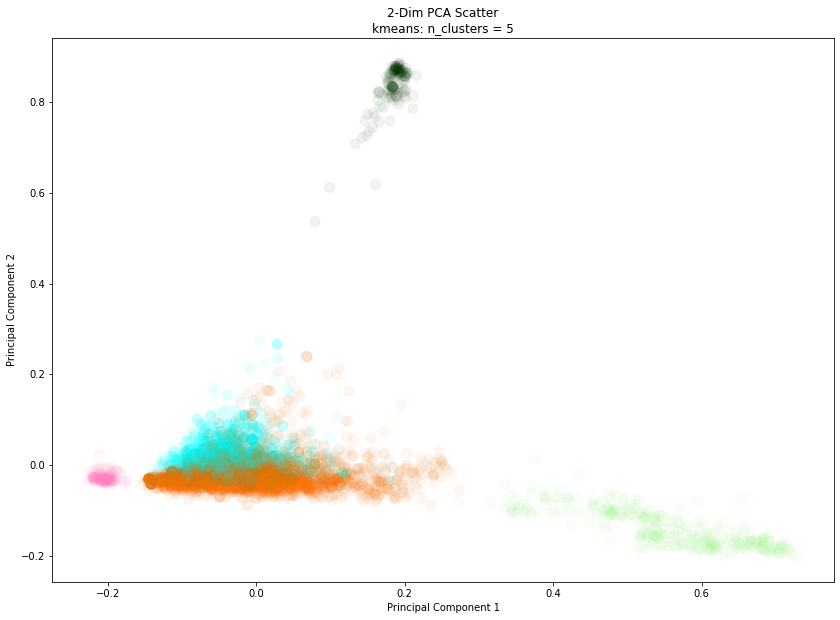

In [32]:
plot_pca_clustering(5, 'kmeans')